In [177]:
import torch
import torch_geometric as tg
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader, Batch
from torch_geometric.utils import degree
from torch.utils.data import random_split

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.models.gcn import ProtGCN

In [178]:
dataset = TUDataset(root='./tmp/PROTEINS', name='PROTEINS').shuffle()

In [179]:
print('Number of graphs: ', len(dataset))
print('\n')
print('Number of features: ', dataset.num_features)
print('\n')
print('Number of classes: ', dataset.num_classes)
print('\n')

print(dataset[0])

Number of graphs:  1113


Number of features:  3


Number of classes:  2


Data(edge_index=[2, 76], x=[21, 3], y=[1])


In [180]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

In [181]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [182]:
for batch in train_loader:
    print(batch)

DataBatch(edge_index=[2, 3728], x=[967, 3], y=[32], batch=[967], ptr=[33])
DataBatch(edge_index=[2, 4998], x=[1341, 3], y=[32], batch=[1341], ptr=[33])
DataBatch(edge_index=[2, 4336], x=[1151, 3], y=[32], batch=[1151], ptr=[33])
DataBatch(edge_index=[2, 4198], x=[1202, 3], y=[32], batch=[1202], ptr=[33])
DataBatch(edge_index=[2, 5472], x=[1513, 3], y=[32], batch=[1513], ptr=[33])
DataBatch(edge_index=[2, 3738], x=[1076, 3], y=[32], batch=[1076], ptr=[33])
DataBatch(edge_index=[2, 5838], x=[1561, 3], y=[32], batch=[1561], ptr=[33])
DataBatch(edge_index=[2, 5262], x=[1463, 3], y=[32], batch=[1463], ptr=[33])
DataBatch(edge_index=[2, 6960], x=[1831, 3], y=[32], batch=[1831], ptr=[33])
DataBatch(edge_index=[2, 3990], x=[1047, 3], y=[32], batch=[1047], ptr=[33])
DataBatch(edge_index=[2, 4316], x=[1147, 3], y=[32], batch=[1147], ptr=[33])
DataBatch(edge_index=[2, 5472], x=[1511, 3], y=[32], batch=[1511], ptr=[33])
DataBatch(edge_index=[2, 4300], x=[1106, 3], y=[32], batch=[1106], ptr=[33])
D

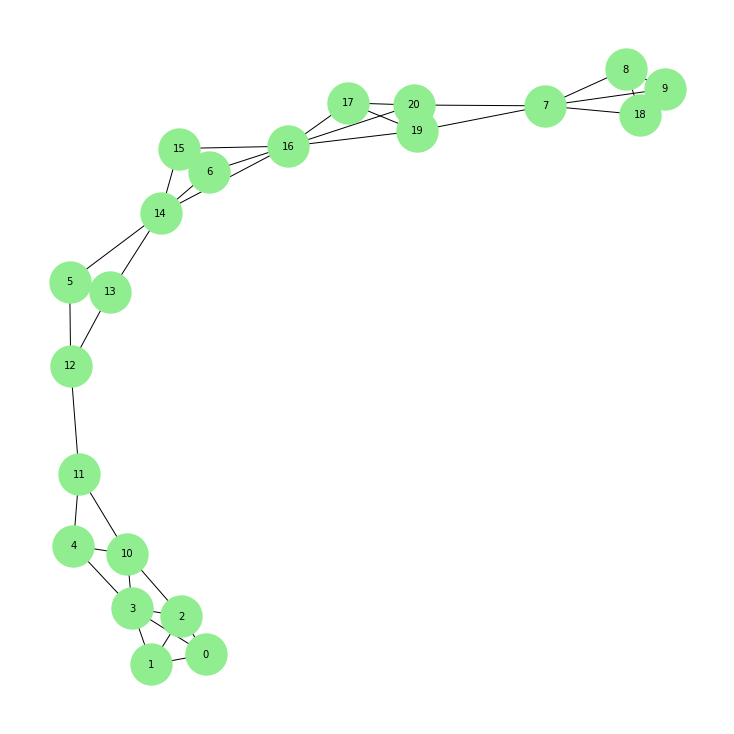

In [183]:
plt.figure(figsize=(10, 10))

graph = nx.Graph()

for i in range(len(dataset[0].edge_index[0])):
    graph.add_edge(dataset[0].edge_index[0][i].item(), dataset[0].edge_index[1][i].item())

nx.draw(graph, with_labels=True, node_size=500, node_color='lightgreen', edge_color='black', linewidths=20, font_size=10)
plt.show()

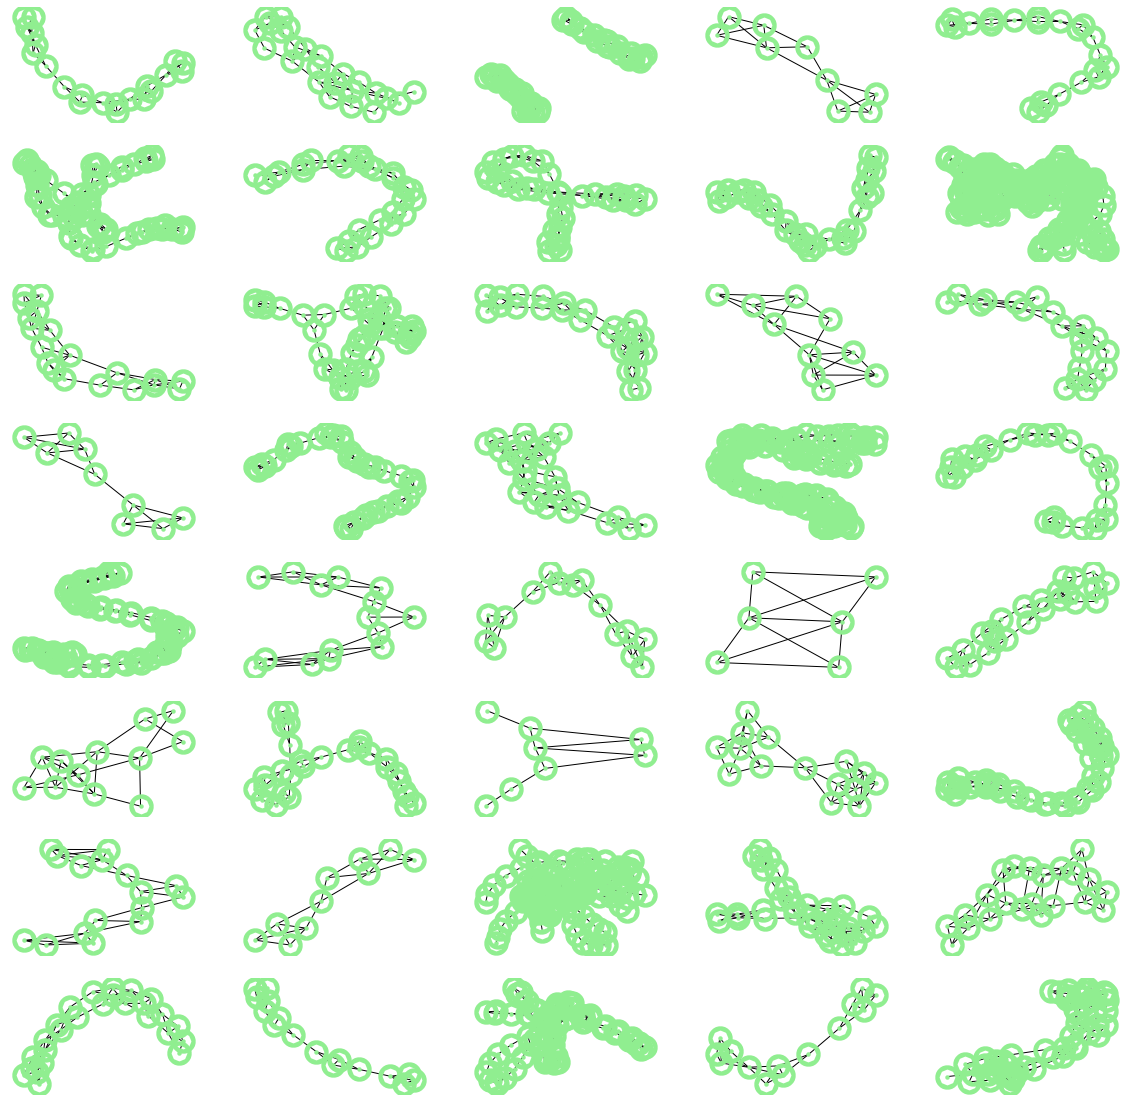

In [184]:
fig, axs = plt.subplots(8, 5, figsize=(20, 20))

for i in range(40):
    graph = nx.Graph()
    for j in range(len(dataset[i].edge_index[0])):
        graph.add_edge(dataset[i].edge_index[0][j].item(), dataset[i].edge_index[1][j].item())
    nx.draw(graph, with_labels=False, node_size=20, node_color='lightgreen', linewidths=20, font_size=10, ax=axs[i//5, i%5])
    
plt.show()

In [185]:
model = ProtGCN(
    
    nfeatures=dataset.num_features,
    nclasses=dataset.num_classes,
    hidden_channels=32
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [186]:
print(model)

ProtGCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (linear): Linear(32, 2, bias=True)
)


In [187]:

def train():
    
    model.train()
    
    acc = 0
    
    for data in train_loader:
        
        optimizer.zero_grad()
        
        _, out = model(data.x, data.edge_index, data.batch)
        
        loss = criterion(out, data.y)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        
        loss.backward()
        optimizer.step()
    
    return loss, acc

@torch.no_grad()
def test():
    
    model.eval()
    loss = 0
    acc = 0

    for data in test_loader:
        
        _, out = model(data.x, data.edge_index, data.batch)
        
        loss += criterion(out, data.y) / len(test_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)
        
    return acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [188]:
NUMBER_OF_EPOCHS = 200

In [189]:
for epoch in range(1, NUMBER_OF_EPOCHS):
    
    loss, acc = train()
    test_acc = test()
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc*100: .2f} %, Test Acc: {test_acc*100:.2f} %')

Epoch: 001, Loss: 0.7599, Train Acc:  58.32 %, Test Acc: 50.00 %
Epoch: 002, Loss: 0.6528, Train Acc:  59.37 %, Test Acc: 48.44 %
Epoch: 003, Loss: 0.7479, Train Acc:  59.32 %, Test Acc: 53.91 %
Epoch: 004, Loss: 0.6600, Train Acc:  59.48 %, Test Acc: 52.34 %
Epoch: 005, Loss: 0.6993, Train Acc:  59.38 %, Test Acc: 52.34 %
Epoch: 006, Loss: 0.6809, Train Acc:  59.43 %, Test Acc: 51.56 %
Epoch: 007, Loss: 0.7168, Train Acc:  59.38 %, Test Acc: 50.00 %
Epoch: 008, Loss: 0.6390, Train Acc:  59.53 %, Test Acc: 52.34 %
Epoch: 009, Loss: 0.7247, Train Acc:  59.40 %, Test Acc: 53.12 %
Epoch: 010, Loss: 0.6550, Train Acc:  59.48 %, Test Acc: 50.00 %
Epoch: 011, Loss: 0.6218, Train Acc:  59.56 %, Test Acc: 50.78 %
Epoch: 012, Loss: 0.6965, Train Acc:  59.40 %, Test Acc: 53.12 %
Epoch: 013, Loss: 0.6832, Train Acc:  59.43 %, Test Acc: 51.56 %
Epoch: 014, Loss: 0.6941, Train Acc:  59.40 %, Test Acc: 52.34 %
Epoch: 015, Loss: 0.7262, Train Acc:  59.35 %, Test Acc: 49.22 %
Epoch: 016, Loss: 0.6540,